In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import re
import os, sys
import json
import pickle
from urllib.parse import urlparse
from urllib.request import urlretrieve, unquote
from scipy import sparse
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from itertools import combinations
from sklearn.metrics import accuracy_score
from tqdm import tqdm

from functions import load_data
from functions import dict_gender_to_gendercategory
from functions import dict_gendercategory_to_gender
from functions import dict_age_to_agecategory
from functions import dict_agecategory_to_age
from functions import load_user_json
from functions import url2domain

from functions import get_time
from functions import get_mode
from functions import make_harmonic_features

from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import f1_score
import seaborn as sns
import datetime
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import LatentDirichletAllocation

In [2]:
df_test, df_train = load_data()

In [3]:
def feature_engineering(df):
    #пол - перевод в категории 
    df['gender_cat'] = df['gender'].map(dict_gender_to_gendercategory)
    
    #возраст - перевод в категории 
    df['age_cat'] = df['age'].map(dict_age_to_agecategory)
    
    #user_json - конвертация строки в json
    df['user_json'] = load_user_json(df['user_json'])
    
    #user_json - вычитываем домен
    df['domain_list'] = df['user_json'].map(lambda x: [url2domain(visit['url']) for visit in x['visits']])
    
    #user_json - вычитываем unix время
    df['time_list'] = df['user_json'].map(lambda x: [visit['timestamp'] for visit in x['visits']])
    
    
    #получаем для юзера список времен посечения страницы (число от 0 до 24)
    df['hours'] = [list(map(get_time,time_list)) for time_list in df['time_list']]
    
    #получаем моду времени посещения страницы
    df['hour_mode'] = [get_mode(hour_list) for hour_list in df['hours']]
    
    #конвертация моды в косинус
    df['hours_harmonics_cos'] = [make_harmonic_features(time_list)[0] for time_list in df['hour_mode']]
    
    #конвертация моды в синус
    df['hours_harmonics_sin'] = [make_harmonic_features(time_list)[1] for time_list in df['hour_mode']]
    
    #количество визитов
    df['visits'] = df['time_list'].apply(len)
    
    #логарифмируем количество визитов
    df['visits'] = np.log1p(df['visits'])
    
    #время между первым и последним посещением
    df['time_range'] = df['time_list'].apply(np.ptp)
    
    #среднее время на посещение
    df['visit_rate'] = df['time_range']/df['visits']
    
    #логарифмируем среднее время на посещение
    df['visit_rate'] = np.log1p(df['visit_rate'])
    
    return df

df_train = feature_engineering(df_train)
df_test = feature_engineering(df_test)

In [5]:
def identity_tokenizer(text):
    return text

def tfidf(train, test):
    '''должна быть колонка domain_list'''
    
    def convert_to_df(data, df):    
        cols = list(map(lambda x: 'tfidf_'+str(x),np.arange(data.shape[1]))) 
        data = data.todense()
        data = np.squeeze(np.asarray(data))
        data = pd.DataFrame(data, columns = cols, index = df.index, dtype = np.float16)
        
        return pd.concat([data,df],axis=1), cols
    
    #tfidf

    tfidf_model = TfidfVectorizer(tokenizer=identity_tokenizer, lowercase=False, max_features = 2000)
    tfidf_model.fit(train['domain_list'].append(test['domain_list']))
    
    train_data = tfidf_model.transform(train['domain_list'])
    test_data = tfidf_model.transform(test['domain_list'])
    
    # tsvd = TruncatedSVD(n_components=200)
    # svd_data = tsvd.fit_transform(sparse_tfidf_domain_list)
    
    train_data, cols = convert_to_df(train_data, train)
    test_data, _ = convert_to_df(test_data, test)
    
    
    return train_data, test_data, tfidf_model, cols

In [6]:
df_train, df_test, tfidf_model, cols = tfidf(df_train, df_test)

In [8]:
import json
from pymystem3 import Mystem
from nltk.corpus import stopwords
from string import punctuation
mystem = Mystem() 
russian_stopwords = stopwords.words("russian")

#Preprocess function
def preprocess_text(text):
    tokens = mystem.lemmatize(text.lower())
    tokens = [token for token in tokens if token not in russian_stopwords\
              and token != " " \
              and token.strip() not in punctuation]
    
    text = " ".join(tokens)
    
    return text

with open('titles-aiohttp.json') as json_file:  
    data = json.load(json_file)
print("data['юрист-михаил-бабин.рф']")
print(data['юрист-михаил-бабин.рф'])
print("data['yaki.kh.ua']")
print(data['yaki.kh.ua'])
data = pd.DataFrame([[x,data[x]['title']] for x in data],columns = ['url','title'])
data['title'] = data['title'].astype(str)
data['title'] = data['title'].map(preprocess_text)
data['title'] = data['title'].map(lambda x: re.sub(r'\W', ' ', x)).map(lambda x: re.sub(r'\s+', ' ', x).strip())


data['юрист-михаил-бабин.рф']
{'domain': 'юрист-михаил-бабин.рф', 'url': 'http://юрист-михаил-бабин.рф', 'title': None, 'keywords': None, 'error': 'Cannot connect to host юрист-михаил-бабин.рф:80 ssl:None [nodename nor servname provided, or not known]'}
data['yaki.kh.ua']
{'domain': 'yaki.kh.ua', 'url': 'http://yaki.kh.ua', 'title': 'Доставка еды на дом в Харькове 24/7 - Якитория', 'keywords': None, 'description': 'Якитория: Выполняем доставку еды на дом в Харькове 24/7. Рестораны Якитория это: ✔Быстро ✔Вкусно ✔Сытно'}


In [10]:
url_dict = {row[1][0]:row[1][1] for row in data.iterrows()}
df_train['domain_list2'] = df_train['domain_list'].map(lambda x: ' '.join([url_dict[y] for y in x if y in url_dict.keys()]))
df_test['domain_list2'] = df_test['domain_list'].map(lambda x: ' '.join([url_dict[y] for y in x if y in url_dict.keys()]))
df_train['domain_list2'] = df_train['domain_list2'].str.split()
df_test['domain_list2'] = df_test['domain_list2'].str.split()

# Gender

In [13]:
def tfidf_titles(train, test):
    '''должна быть колонка domain_list'''
    
    def convert_to_df(data, df):    
        cols = list(map(lambda x: 'tfidf_titles_'+str(x),np.arange(data.shape[1]))) 
        data = data.todense()
        data = np.squeeze(np.asarray(data))
        data = pd.DataFrame(data, columns = cols, index = df.index, dtype = np.float16)
        
        return pd.concat([data,df],axis=1), cols
    
    #tfidf

    tfidf_model = TfidfVectorizer(tokenizer=identity_tokenizer, lowercase=False, max_features = 2000)
    tfidf_model.fit(train['domain_list2'].append(test['domain_list2']))
    
    train_data = tfidf_model.transform(train['domain_list2'])
    test_data = tfidf_model.transform(test['domain_list2'])
    
    # tsvd = TruncatedSVD(n_components=200)
    # svd_data = tsvd.fit_transform(sparse_tfidf_domain_list)
    
    train_data, cols = convert_to_df(train_data, train)
    test_data, _ = convert_to_df(test_data, test)
    
    
    return train_data, test_data, tfidf_model, cols

In [14]:
df_train, df_test, tfidf_titles_model, cols_titles = tfidf_titles(df_train, df_test)

## cv

In [19]:
params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'auc',
    'num_leaves': 31,
    'learning_rate': 0.01,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0
}

In [29]:
#получаем out of fold (oof) предсказания
num_boost = 2700

SPLITS = 5
col_target = 'gender_cat'
cols_features = cols+cols_titles+['hours_harmonics_cos','hours_harmonics_sin','visit_rate','time_range','visits']

kf = StratifiedKFold(n_splits=SPLITS, shuffle=True, random_state=0)
kf.get_n_splits(df_train)
scores = {}

for fold, (train_index, test_index) in enumerate(kf.split(np.zeros(len(df_train)), df_train[col_target])):
    lda = LatentDirichletAllocation(n_components=30, random_state=0)
    lda.fit(df_train.loc[df_train.index[train_index], cols]) 
    data = lda.transform(df_train.loc[df_train.index[train_index], cols])
    data = pd.DataFrame(data,index = df_train.index[train_index], columns=list(map(lambda x: 'lda_'+str(x),np.arange(data.shape[1])))) 
    
  
    lda_titles = LatentDirichletAllocation(n_components=30, random_state=0)
    lda_titles.fit(df_train.loc[df_train.index[train_index], cols_titles]) 
    data_titles = lda_titles.transform(df_train.loc[df_train.index[train_index], cols_titles])
    data_titles = pd.DataFrame(data_titles,index = df_train.index[train_index], columns=list(map(lambda x: 'lda_titles_'+str(x),np.arange(data.shape[1])))) 
    
    train = pd.concat([
        df_train.loc[df_train.index[train_index], cols_features],
        data,
        data_titles
    ],axis=1).loc[df_train.index[train_index]]
    
    data = lda.transform(df_train.loc[df_train.index[test_index], cols])
    data = pd.DataFrame(data,index = df_train.index[test_index], columns=list(map(lambda x: 'lda_'+str(x),np.arange(data.shape[1])))) 
    
    data_titles = lda_titles.transform(df_train.loc[df_train.index[test_index], cols_titles])
    data_titles = pd.DataFrame(data_titles,index = df_train.index[test_index], columns=list(map(lambda x: 'lda_titles_'+str(x),np.arange(data.shape[1])))) 
    
    test = pd.concat([
        df_train.loc[df_train.index[test_index], cols_features],
        data,
        data_titles
    ],axis=1).loc[df_train.index[test_index]]
    
    
    # Подготовка данных в нужном формате 
    print('Current Fold: {}\n'.format(fold+1))
    dtrain = lgb.Dataset(data=train,
                         label=df_train.loc[df_train.index[train_index], col_target])
    dvalid = lgb.Dataset(data=test,
                         label=df_train.loc[df_train.index[test_index], col_target])

    # Обучение 
    evals_result = {}
    model = lgb.train(params=params, 
                      train_set=dtrain, 
                      valid_sets=[dtrain, dvalid],
                      valid_names=['train', 'eval'],
                      num_boost_round=num_boost, 
                      evals_result=evals_result,
                      verbose_eval=False)
    
    df_train.loc[df_train.index[test_index], 'PREDICT'] = model.predict(test[model.feature_name()])

    # Построение прогнозов при разном виде взаимодействия
    scores[fold] = evals_result['eval']['auc']


/home/madjuice/Documents/Python/venv/lib/python3.7/site-packages/numpy/core/_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)
/home/madjuice/Documents/Python/venv/lib/python3.7/site-packages/numpy/core/_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)
/home/madjuice/Documents/Python/venv/lib/python3.7/site-packages/numpy/core/_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)


Current Fold: 1



/home/madjuice/Documents/Python/venv/lib/python3.7/site-packages/numpy/core/_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)
/home/madjuice/Documents/Python/venv/lib/python3.7/site-packages/numpy/core/_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)
/home/madjuice/Documents/Python/venv/lib/python3.7/site-packages/numpy/core/_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)


Current Fold: 2



/home/madjuice/Documents/Python/venv/lib/python3.7/site-packages/numpy/core/_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)
/home/madjuice/Documents/Python/venv/lib/python3.7/site-packages/numpy/core/_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)
/home/madjuice/Documents/Python/venv/lib/python3.7/site-packages/numpy/core/_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)


Current Fold: 3



/home/madjuice/Documents/Python/venv/lib/python3.7/site-packages/numpy/core/_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)
/home/madjuice/Documents/Python/venv/lib/python3.7/site-packages/numpy/core/_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)
/home/madjuice/Documents/Python/venv/lib/python3.7/site-packages/numpy/core/_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)


Current Fold: 4



/home/madjuice/Documents/Python/venv/lib/python3.7/site-packages/numpy/core/_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)
/home/madjuice/Documents/Python/venv/lib/python3.7/site-packages/numpy/core/_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)
/home/madjuice/Documents/Python/venv/lib/python3.7/site-packages/numpy/core/_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)


Current Fold: 5



In [31]:
scores = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in scores.items()]))
score_max = scores.mean(axis=1).max()
num_boost = np.argmax(scores.mean(axis=1))
std = scores.std(axis=1)[num_boost]
print(num_boost, score_max, std)

1724 0.7793246122471934 0.0018776320846505834


/home/madjuice/Documents/Python/venv/lib/python3.7/site-packages/numpy/core/fromnumeric.py:51: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  return getattr(obj, method)(*args, **kwds)


In [32]:
tfidf_titles_model.vocabulary_

{'магазин': 1173,
 'подарок': 1403,
 'товар': 1798,
 'дом': 893,
 'яндекс': 1982,
 'новость': 1283,
 'главный': 825,
 'сегодня': 1645,
 'самый': 1627,
 'свежий': 1634,
 'последний': 1437,
 'россия': 1583,
 'онлайн': 1328,
 'сотовый': 1703,
 'телефон': 1785,
 'цена': 1908,
 'мобильный': 1220,
 'каталог': 1056,
 'обзор': 1294,
 'смартфон': 1677,
 '101': 8,
 'ru': 474,
 'радио': 1521,
 'бесплатно': 707,
 'парень': 1370,
 'секс': 1648,
 'знакомство': 974,
 'регистрация': 1545,
 'смс': 1682,
 'интерфакс': 1018,
 'телеканал': 1783,
 'смотреть': 1681,
 'видео': 770,
 'телепрограмма': 1784,
 'кино': 1063,
 'сериал': 1656,
 'шоу': 1940,
 'android': 66,
 'совет': 1689,
 'помощь': 1429,
 'клуб': 1071,
 'эксперт': 1955,
 'dns': 148,
 'none': 400,
 'аналитический': 670,
 'компьютер': 1089,
 'компьютерный': 1090,
 'рынок': 1601,
 '403': 30,
 'forbidden': 201,
 'from': 213,
 'биатлон': 710,
 'мир': 1211,
 'популярный': 1431,
 'сайт': 1620,
 'сезон': 1646,
 '2018': 18,
 '2019': 19,
 'чемпионат': 1921,

## train

In [56]:
params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'auc',
    'num_leaves': 31,
    'learning_rate': 0.01,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0
}
num_boost = 2000

In [33]:
for fold in np.arange(0,5,1):
    lda = pickle.load(open('models/lda'+str(fold)+'.pkl', 'rb'))
    lda_titles = pickle.load(open('models/lda_titles'+str(fold)+'.pkl', 'rb'))

    data = lda.transform(df_test[cols])
    data = pd.DataFrame(data,index = df_test.index, columns=list(map(lambda x: 'lda_'+str(x),np.arange(data.shape[1])))) 

    data_titles = lda_titles.transform(df_test[cols_titles])
    data_titles = pd.DataFrame(data_titles,index = df_test.index, columns=list(map(lambda x: 'lda_titles_'+str(x),np.arange(data.shape[1])))) 
    
    test = pd.concat([
        df_test[cols_features],
        data,
        data_titles
    ],axis=1)
    
    model_gender = lgb.Booster(model_file='models/vb_lgb_model_gender'+str(fold)+'.txt')
    
    df_test['PREDICT'+str(fold)] = model_gender.predict(test[model_gender.feature_name()], num_iter = 1724)

In [58]:
col_target = 'gender_cat'
cols_features = cols+cols_titles+['hours_harmonics_cos','hours_harmonics_sin','visit_rate','time_range','visits']

lda = LatentDirichletAllocation(n_components=30, random_state=0)
lda.fit(df_train[cols]) 

lda_titles = LatentDirichletAllocation(n_components=30, random_state=0)
lda_titles.fit(df_train.loc[df_train.index[train_index], cols_titles]) 

data = lda.transform(df_train[cols])
data = pd.DataFrame(data,index = df_train.index, columns=list(map(lambda x: 'lda_'+str(x),np.arange(data.shape[1])))) 


data_titles = lda_titles.transform(df_train[cols_titles])
data_titles = pd.DataFrame(data_titles,index = df_train.index, columns=list(map(lambda x: 'lda_titles_'+str(x),np.arange(data.shape[1])))) 
    
train = pd.concat([
    df_train[cols_features],
    data,
    data_titles
],axis=1)

with open('../models/lda.pkl', 'wb') as f:
    pickle.dump(lda, f)
with open('../models/lda_titles.pkl', 'wb') as f:
    pickle.dump(lda_titles, f)

lgb_train = lgb.Dataset(train, df_train[col_target])

model_gender = lgb.train(params,lgb_train,num_boost_round=num_boost)

model_gender.save_model('../models/vb_lgb_model_gender.txt')

/opt/anaconda/envs/bd9/lib/python3.6/site-packages/numpy/core/_methods.py:32: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims)


In [35]:

data = lda.transform(df_test[cols])
data = pd.DataFrame(data,index = df_test.index, columns=list(map(lambda x: 'lda_'+str(x),np.arange(data.shape[1])))) 
test = pd.concat([
    df_test[cols_features],
    data
],axis=1)


df_test['PREDICT'] = model_gender.predict(test[model_gender.feature_name()])

# AGE

## cv

In [43]:
params = {
    'boosting_type': 'gbdt',
    'objective': 'multiclass',
    'metric': 'multi_error',#['multiclass','multi_error'],
    'num_class': 5,
    'num_leaves': 31,
    'learning_rate': 0.01,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0
}

In [45]:
#получаем out of fold(oof) предсказания
for col in ['PREDICT_AGE1', 'PREDICT_AGE2', 'PREDICT_AGE3', 'PREDICT_AGE4', 'PREDICT_AGE5']:
    df_train[col] = np.nan

SPLITS = 5
col_target = 'age_cat'
cols_features = cols+cols_titles+['hours_harmonics_cos','hours_harmonics_sin','visit_rate','time_range','visits']
num_boost = 1000

kf = StratifiedKFold(n_splits=SPLITS, shuffle=True, random_state=0)
kf.get_n_splits(df_train)
scores = {}

for fold, (train_index, test_index) in enumerate(kf.split(np.zeros(len(df_train)), df_train[col_target])):
    lda = pickle.load(open('models/lda'+str(fold)+'.pkl', 'rb'))
    lda_titles = pickle.load(open('models/lda_titles'+str(fold)+'.pkl', 'rb'))

    data = pd.read_pickle('data_train'+str(fold)+'.pkl')    
    data_titles = pd.read_pickle('data_titles_train'+str(fold)+'.pkl')
    
    
    train = pd.concat([
        df_train.loc[df_train.index[train_index], cols_features],
        data,
        data_titles
    ],axis=1).loc[df_train.index[train_index]]
    data = pd.read_pickle('data_test'+str(fold)+'.pkl')
    data_titles = pd.read_pickle('data_titles_test'+str(fold)+'.pkl')

    
    test = pd.concat([
        df_train.loc[df_train.index[test_index], cols_features],
        data,
        data_titles
    ],axis=1).loc[df_train.index[test_index]]
    
    # Подготовка данных в нужном формате 
    print('Current Fold: {}\n'.format(fold+1))
    dtrain = lgb.Dataset(data=train,
                         label=df_train.loc[df_train.index[train_index], col_target])
    dvalid = lgb.Dataset(data=test,
                         label=df_train.loc[df_train.index[test_index], col_target])

    # Обучение 
    evals_result = {}
    model = lgb.train(params=params, 
                      train_set=dtrain, 
                      valid_sets=[dtrain, dvalid],
                      valid_names=['train', 'eval'],
                      num_boost_round=num_boost, 
                      evals_result=evals_result,
#                       categorical_feature=cols_cat, 
                      verbose_eval=False)

    model.save_model('models/vb_lgb_model_age'+str(fold)+'.txt')
    # Построение прогнозов на TARGET: 0/1
    df_train.loc[df_train.index[test_index], ['PREDICT_AGE1', 'PREDICT_AGE2', 'PREDICT_AGE3', 'PREDICT_AGE4', 'PREDICT_AGE5']] = model.predict(test[model.feature_name()])
    # Построение прогнозов при разном виде взаимодействия
    scores[fold] = evals_result['eval']['multi_error']
df_train['PREDICT_AGE'] = np.argmax(df_train[['PREDICT_AGE1', 'PREDICT_AGE2', 'PREDICT_AGE3', 'PREDICT_AGE4', 'PREDICT_AGE5']].values,axis=1)

Current Fold: 1

Current Fold: 2

Current Fold: 3

Current Fold: 4

Current Fold: 5



In [46]:
scores = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in scores.items()]))
score_max = scores.mean(axis=1).min()
num_boost = np.argmin(scores.mean(axis=1))
std = scores.std(axis=1)[num_boost]
print(num_boost, score_max, std)

973 0.5459901432383625 0.0015387931422457032


/home/madjuice/Documents/Python/venv/lib/python3.7/site-packages/numpy/core/fromnumeric.py:51: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.
  return getattr(obj, method)(*args, **kwds)


## train

In [62]:
params = {
    'boosting_type': 'gbdt',
    'objective': 'multiclass',
    'metric': 'multi_error',#['multiclass','multi_error'],
    'num_class': 5,
    'num_leaves': 31,
    'learning_rate': 0.01,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0
}

In [47]:
for fold in np.arange(0,5,1):
    for col in ['PREDICT_AGE1', 'PREDICT_AGE2', 'PREDICT_AGE3', 'PREDICT_AGE4', 'PREDICT_AGE5']:
        df_test[col+str(fold)]=0.0

In [49]:
for fold in np.arange(0,5,1):
    lda = pickle.load(open('models/lda'+str(fold)+'.pkl', 'rb'))
    lda_titles = pickle.load(open('models/lda_titles'+str(fold)+'.pkl', 'rb'))

    data = lda.transform(df_test[cols])
    data = pd.DataFrame(data,index = df_test.index, columns=list(map(lambda x: 'lda_'+str(x),np.arange(data.shape[1])))) 

    data_titles = lda_titles.transform(df_test[cols_titles])
    data_titles = pd.DataFrame(data_titles,index = df_test.index, columns=list(map(lambda x: 'lda_titles_'+str(x),np.arange(data.shape[1])))) 
    
    test = pd.concat([
        df_test[cols_features],
        data,
        data_titles
    ],axis=1)
    
    model_age = lgb.Booster(model_file='models/vb_lgb_model_age'+str(fold)+'.txt')
    
    df_test[['PREDICT_AGE1'+str(fold), 'PREDICT_AGE2'+str(fold), 'PREDICT_AGE3'+str(fold), 'PREDICT_AGE4'+str(fold), 'PREDICT_AGE5'+str(fold)]] = model_age.predict(test[model_age.feature_name()], num_iter = 973)

for age in np.arange(1,6,1):
    df_test['PREDICT_AGE'+str(age)] = df_test[['PREDICT_AGE'+str(age)+'0','PREDICT_AGE'+str(age)+'1','PREDICT_AGE'+str(age)+'2','PREDICT_AGE'+str(age)+'3','PREDICT_AGE'+str(age)+'4']].mean(axis=1)
    
df_test['PREDICT_AGE'] = np.argmax(df_test[['PREDICT_AGE1', 'PREDICT_AGE2', 'PREDICT_AGE3', 'PREDICT_AGE4', 'PREDICT_AGE5']].values,axis=1)

In [50]:
df_test.to_pickle('df_test_fin.pkl')
df_train.to_pickle('df_train_fin.pkl')

In [53]:
df_test['PREDICT'] = df_test[['PREDICT'+'0','PREDICT'+'1','PREDICT'+'2','PREDICT'+'3','PREDICT'+'4']].mean(axis=1)

In [ ]:
df_test['PREDICT'+str(fold)]

In [ ]:
for fold in np.arange(0,5,1):
    df_test[['PREDICT1'+str(fold), 'PREDICT2'+str(fold), 'PREDICT3'+str(fold), 'PREDICT4'+str(fold), 'PREDICT5'+str(fold)]] = model_age.predict(test[model_age.feature_name()], num_iter = 973)


In [63]:
col_target = 'age_cat'
cols_features = cols+cols_titles+['hours_harmonics_cos','hours_harmonics_sin','visit_rate','time_range','visits']
num_boost = 536

lda = LatentDirichletAllocation(n_components=30, random_state=0)
lda.fit(df_train[cols]) 

lda_titles = LatentDirichletAllocation(n_components=30, random_state=0)
lda_titles.fit(df_train.loc[df_train.index[train_index], cols_titles]) 

data = lda.transform(df_train[cols])
data = pd.DataFrame(data,index = df_train.index, columns=list(map(lambda x: 'lda_'+str(x),np.arange(data.shape[1])))) 


data_titles = lda_titles.transform(df_train[cols_titles])
data_titles = pd.DataFrame(data_titles,index = df_train.index, columns=list(map(lambda x: 'lda_titles_'+str(x),np.arange(data.shape[1])))) 
    
train = pd.concat([
    df_train[cols_features],
    data,
    data_titles
],axis=1)

    
with open('../models/lda.pkl', 'wb') as f:
    pickle.dump(lda, f)
with open('../models/lda_titles.pkl', 'wb') as f:
    pickle.dump(lda_titles, f)
    
lgb_train = lgb.Dataset(train, df_train[col_target])

model_age = lgb.train(params,lgb_train,num_boost_round=num_boost)
model_age.save_model('../models/vb_lgb_model_age.txt')

/opt/anaconda/envs/bd9/lib/python3.6/site-packages/numpy/core/_methods.py:32: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims)


In [82]:
for col in ['PREDICT_AGE1', 'PREDICT_AGE2', 'PREDICT_AGE3', 'PREDICT_AGE4', 'PREDICT_AGE5']:
    df_test[col]=0.0

In [85]:

data = lda.transform(df_test[cols])
data = pd.DataFrame(data,index = df_test.index, columns=list(map(lambda x: 'lda_'+str(x),np.arange(data.shape[1])))) 


data_titles = lda_titles.transform(df_test[cols_titles])
data_titles = pd.DataFrame(data_titles,index = df_test.index, columns=list(map(lambda x: 'lda_titles_'+str(x),np.arange(data.shape[1])))) 
    
test = pd.concat([
    df_test[cols_features],
    data,
    data_titles
],axis=1)

df_test[['PREDICT_AGE1', 'PREDICT_AGE2', 'PREDICT_AGE3', 'PREDICT_AGE4', 'PREDICT_AGE5']] = model_age.predict(test[model_age.feature_name()])
df_test['PREDICT_AGE'] = np.argmax(df_test[['PREDICT_AGE1', 'PREDICT_AGE2', 'PREDICT_AGE3', 'PREDICT_AGE4', 'PREDICT_AGE5']].values,axis=1)

In [86]:

data = lda.transform(df_test[cols])
data = pd.DataFrame(data,index = df_test.index, columns=list(map(lambda x: 'lda_'+str(x),np.arange(data.shape[1])))) 


data_titles = lda_titles.transform(df_test[cols_titles])
data_titles = pd.DataFrame(data_titles,index = df_test.index, columns=list(map(lambda x: 'lda_titles_'+str(x),np.arange(data.shape[1])))) 
    
test = pd.concat([
    df_test[cols_features],
    data,
    data_titles
],axis=1)

df_test['PREDICT'] = model_gender.predict(test[model_gender.feature_name()])

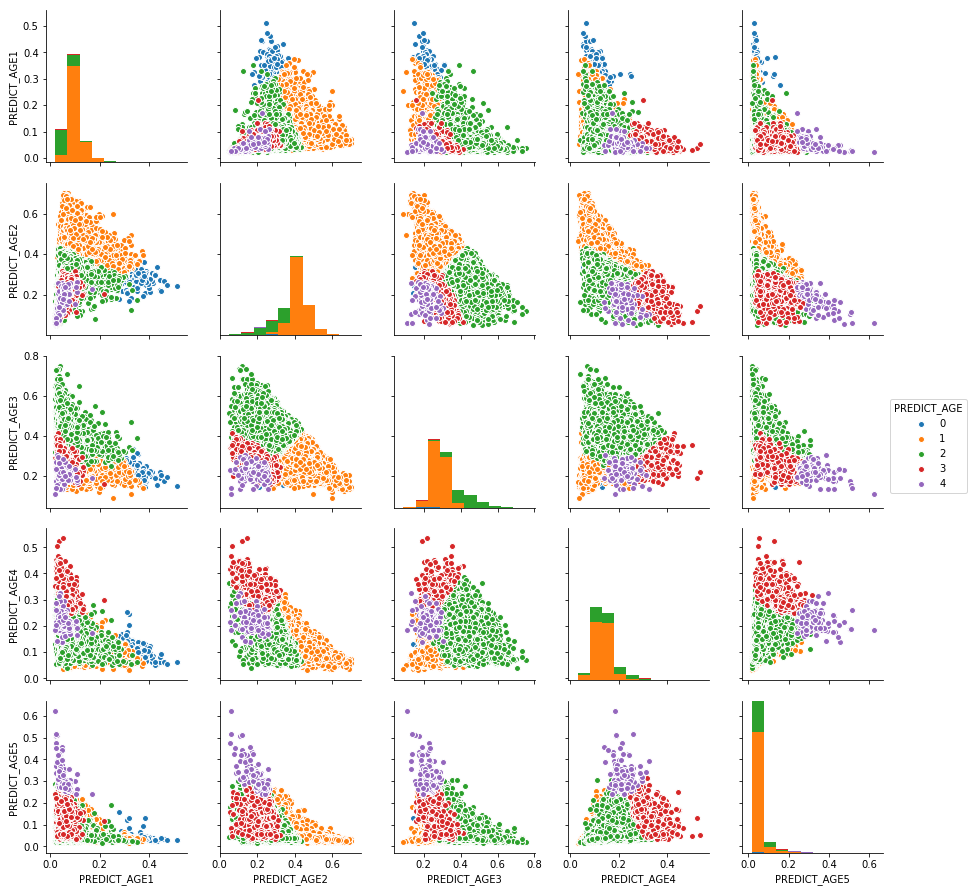

In [50]:
# sns.pairplot(df_train,vars = col_list, hue='PREDICT_AGE')